# Homework 2
This notebook provides some skeleton code to get you started on the homework. Add in your own code and markdown cells to answer the homework questions. If you want to submit the notebook as a PDF, make sure your code and markdowns are clear and concise to make grading easy for the TAs.
This notebook can be opened in Colab Open In Colab

Before starting, select "Runtime->Factory reset runtime" to start with your directories and environment in the base state.

If you want to save changes to the notebook, select "File->Save a copy in Drive" from the top menu in Colab. This will save the notebook in your Google Drive.

**Note**: you should use a GPU or TPU for this assignment.  In the top left menu select Runtime->Change runtime type and choose any GPU or TPU.



# Clones, installs, and imports

## Clone GitHub Repository
This will clone the repository to your machine. This includes the code and data files. Then change into the directory of the repository.

In [ ]:
!git clone https://github.com/zlisto/social_media_analytics

import os
os.chdir("social_media_analytics")

Cloning into 'social_media_analytics'...
remote: Enumerating objects: 660, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 660 (delta 114), reused 191 (delta 81), pack-reused 435
Receiving objects: 100% (660/660), 74.68 MiB | 19.33 MiB/s, done.
Resolving deltas: 100% (346/346), done.
Updating files: 100% (66/66), done.


## Import packages

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import gensim.downloader as api
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from transformers import RobertaTokenizer, RobertaModel
import torch

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


import sklearn.cluster as cluster
from sklearn import metrics
from scipy import stats

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator



import scripts.TextAnalysis as ta

#this code makes the default font sizes big in plots
plt.rcParams.update({'axes.labelsize': 18,
                     'xtick.labelsize': 14,
                     'ytick.labelsize': 14})


# Problem 1. Cluster a User's Tweets (57 points)

In this problem we are going to cluster the tweets of a single user.  Our goal is to determine different topics this person tweets about.  

The user is social media influencer Kim Kardashian, with screen name KimKardashian.

#### 1. (12 points) Load tweets

The tweets are in the file `"data/HW2.csv"`. Load the tweets into a dataframe `df`.  Remove all columns except `"screen_name"` and `"text"`.   Then, use the `text_clean` function to clean the text and remove any clean tweets with length equal to zero.  Now make a new dataframe `df_kim` which is a copy of `df` but only has the tweets with `screen_name` `"KimKardashian"`. We need to make it a copy so that we can add columns to `df_kim` later.

How many tweets are in `df_kim` after this process?  Print out your answer and print the head of `df_kim`.



In [ ]:
# prompt: The tweets are in the file "data/HW2.csv". Load the tweets into a dataframe df. Remove all columns except "screen_name" and "text". Then, use the text_clean function to clean the text and remove any clean tweets with length equal to zero. Now make a new dataframe df_kim which is a copy of df but only has the tweets with screen_name "KimKardashian". We need to make it a copy so that we can add colu

import pandas as pd

# Load the tweets into a dataframe df
df = pd.read_csv("data/HW2.csv")

# Remove all columns except "screen_name" and "text"
df = df[["screen_name", "text"]]

# Clean the text and remove any clean tweets with length equal to zero
df['text_clean'] = df['text'].apply(ta.clean_tweet)  #clean the tweets
df = df[df['text_clean'].str.len() >0]  #remove cleaned tweets of lenght 0

# Make a new dataframe df_kim which is a copy of df but only has the tweets with screen_name "KimKardashian"
df_kim = df[df["screen_name"] == "KimKardashian"].copy()

# Print the number of tweets in df_kim
print(f"Number of tweets in df_kim: {len(df_kim)}")

# Print the head of df_kim
print(df_kim.head())


Number of tweets in df_kim: 941
       screen_name                                               text  \
788  KimKardashian  Just added new items to my #KardashianKloset üõç...   
789  KimKardashian  RT @skims: Run, don‚Äôt walk. The ultra-flatteri...   
790  KimKardashian  still spamming vacay pics üíï https://t.co/yBUDo...   
791  KimKardashian  Let‚Äôs exercise together in Kim Kardashian: Hol...   
792  KimKardashian  Caramel Orchid is todays vibe https://t.co/oOe...   

                                            text_clean  
788        just added new items to my kardashiankloset  
789  skims run dont walk the ultraflattering sheer ...  
790                          still spamming vacay pics  
791  lets exercise together in kim kardashian holly...  
792                      caramel orchid is todays vibe  


#### 2. (6 points) TF Embedding
Calculate the term frequency embedding of the KimKardashian tweets.  

How big is the vocabulary?  Print your answer.

In [ ]:
tf_vectorizer = CountVectorizer(min_df=5, stop_words='english')
tf_embedding = tf_vectorizer.fit_transform(df_kim['text_clean'])
tf_feature_names = tf_vectorizer.get_feature_names_out()

nvocab = len(tf_feature_names)
ntweets = len(df_kim.text_clean)
print(f"{ntweets} tweets, {nvocab} words in vocabulary")
print(f"TF embedding shape is {tf_embedding.shape}")

941 tweets, 349 words in vocabulary
TF embedding shape is (941, 349)


#### 3. (8 points) Fit LDA Model

Fit an LDA model to the KimKardashian tweets with 3 topics.  



In [ ]:
%%time
num_topics = 3
lda_model = LatentDirichletAllocation(n_components=num_topics, max_iter=3,
                                learning_method='online', learning_offset=50.,
                                random_state=0)
lda_model.fit(tf_embedding)

CPU times: user 474 ms, sys: 3.37 ms, total: 478 ms
Wall time: 481 ms


LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=3, n_components=3, random_state=0)

#### 4. (4 points) Plot Topics

Make a separate barplot for each topic with the top 10 words in each topic vs their weight in the LDA topic vector. Make sure you label the axes and title each plot with the topic number.

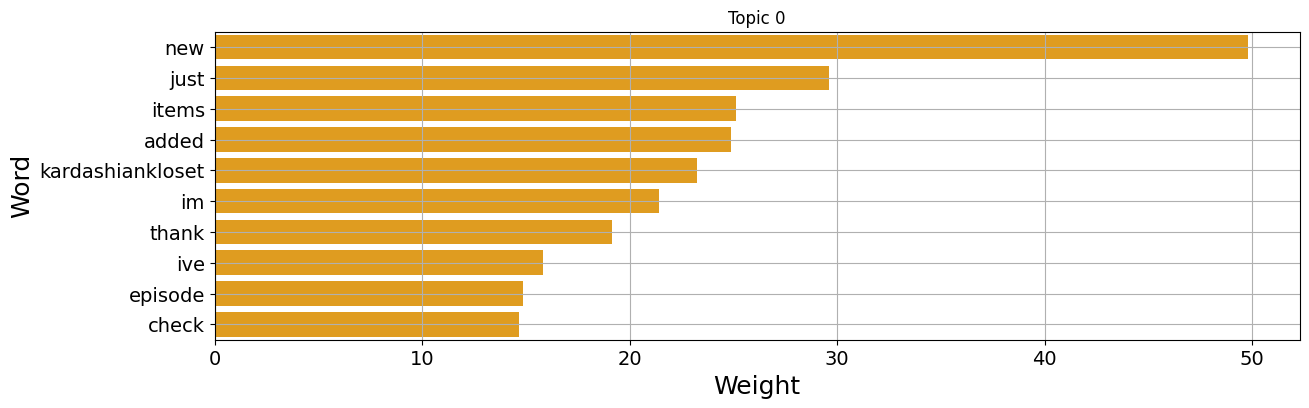

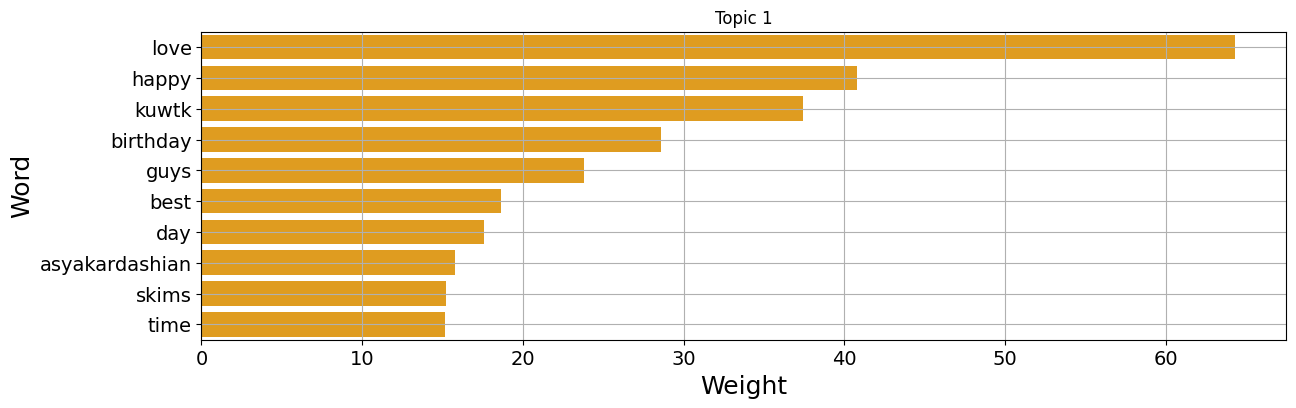

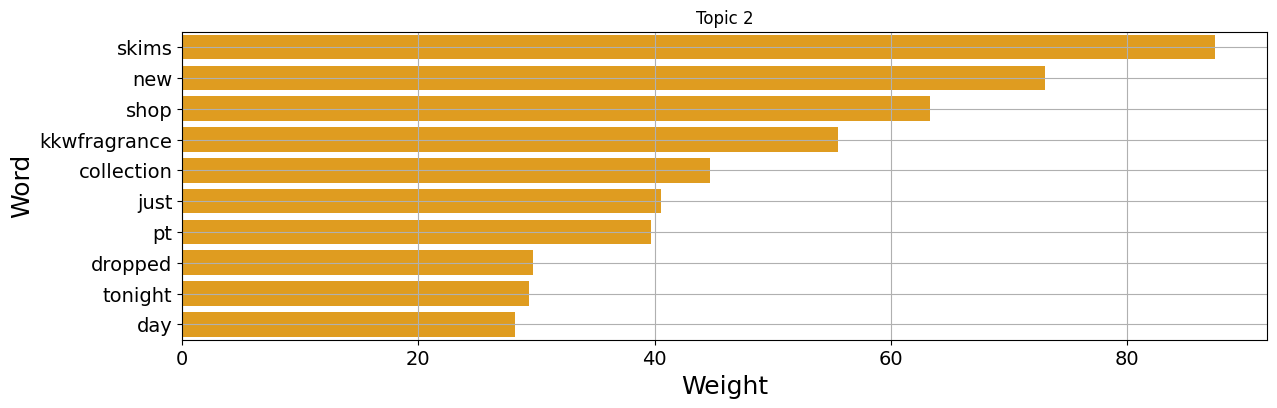

In [ ]:
topic_word_matrix = lda_model.components_

for i in range(num_topics):
  # Get the indices of the top words in descending order
  top_word_indices = np.argsort(topic_word_matrix[i])[-10:][::-1]

  # Get the top words and corresponding weights using the indices
  top_words = tf_feature_names[top_word_indices]
  top_weights = topic_word_matrix[i][top_word_indices]

  # Create a DataFrame for plotting
  df_topic = pd.DataFrame({'Word': top_words, 'Weight': top_weights})

  # Plotting
  plt.figure(figsize=(14, 4))
  sns.barplot(data=df_topic, y='Word', x='Weight', color='orange')
  plt.grid()
  plt.title(f"Topic {i}")
  plt.show()


#### 5. (5 points) LDA Embedding

Use the fit LDA model to convert the tf embedding into a topic vector embedding for the tweets.  

What is the dimension of the embedding?  Print your answer.

In [ ]:
# prompt: transform tf_embedding in lda embeddings using the fit lda_model

lda_embedding = lda_model.transform(tf_embedding)
print(f"{ntweets} tweets, {num_topics} topics in LDA model")
print(f"shape of lda embedding is {lda_embedding.shape}")

941 tweets, 3 topics in LDA model
shape of lda embedding is (941, 3)


#### 6. (9 points) K-Means Clustering

Calculate the k-means clusters of the LDA topic vectors using 3 clusters.  Add a column to `df_kim` called `"kmeans_label_lda"` that contains the k-means cluster labels.

In [ ]:
# prompt: Calculate the k-means clusters of the LDA topic vectors using 3 clusters. Add a column to df_kim called "kmeans_label_lda" that contains the k-means cluster labels.
n_clusters = 3
kmeans_label_lda = cluster.KMeans(n_clusters).fit_predict(lda_embedding)

df_kim['kmeans_label_lda'] = [str(x) for x in kmeans_label_lda]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#### 7. (13 points) Cluster Wordclouds

Plot the word cloud for each cluster (a `for` loop might be useful here).  Don't forget to remove stopwords.   Also add `"kimkardashian"` (all lowercase) to the stopwords set.  Since Kim's screen name is a common word in this corpus, we don't need to display it in the wordclouds.

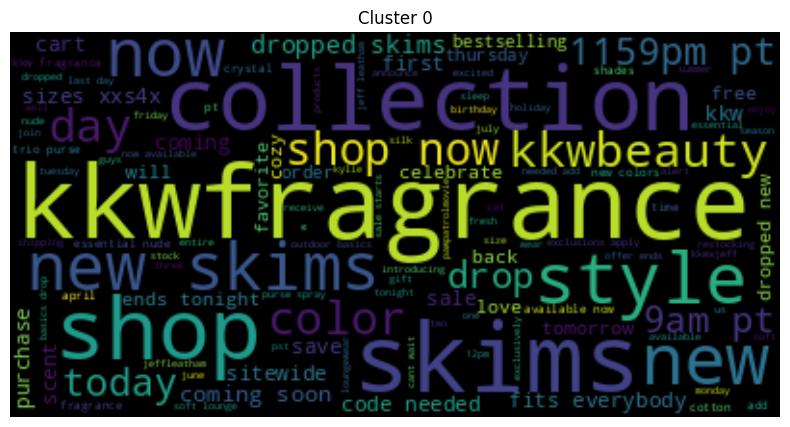

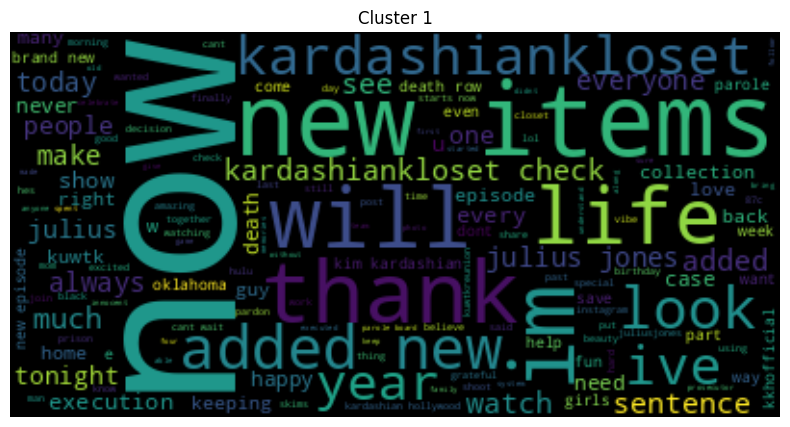

In [ ]:
# prompt: Plot the word cloud for each cluster (a for loop might be useful here). Don't forget to remove stopwords. Also add "kimkardashian" (all lowercase) to the stopwords set. Since Kim's screen name is a common word in this corpus, we don't need to display it in the wordclouds.

import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)
stopwords.add('kimkardashian')

for label in range(n_clusters):
  cluster_tweets = df_kim[df_kim['kmeans_label_lda'] == str(label)]
  text = " ".join(cluster_tweets['text_clean'].values)
  wordcloud = WordCloud(stopwords=stopwords).generate(text)

  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.title(f"Cluster {label}")
  plt.show()


#### 8. (0 points) Cluster Analysis

If you are not familiar with American pop culture these word clouds may not make any sense to you.  But if you are, or are curious about Kim Kardashian's tweet topics, try to provide a unifying theme for each cluster based on the word clouds.  This question is for fun, so no worries if you want to skip it.

# Problem 2. Finding User Communities by Clustering Tweets (54 points)

In this problem we are going to cluster the tweets from multiple Twitter users.  We are going to try and form communities of people from these tweet clusters.  

#### 1. (5 points) Load tweets

Load the tweets into a dataframe and call it `df`. The tweets are in the file `"data/HW2.csv"`.  

How many tweets in `df`?  Print your answer.

How many unique screen names are in `df`?  Print out the screen names.



In [ ]:
# prompt: Load the tweets into a dataframe and call it df. The tweets are in the file "data/HW2.csv".  How many tweets in df? Print your answer.  How many unique screen names are in df? Print out the screen names.

import pandas as pd

# Load the tweets into a dataframe and call it df
df = pd.read_csv("data/HW2.csv")

# How many tweets in df?
print(f"Number of tweets: {len(df)}")

# How many unique screen names are in df?
unique_screen_names = df["screen_name"].unique()
print(f"Number of unique screen names: {len(unique_screen_names)}")

# Print out the screen names
print(f"Screen names: {unique_screen_names}")


Number of tweets: 5184
Number of unique screen names: 5
Screen names: ['KylieJenner' 'KimKardashian' 'IlhanMN' 'AOC' 'RashidaTlaib']


#### 2. (9 points) Transformer Embedding

Calculate the transformer embedding of the tweets using the `"roberta-base"`  model from Huggingface.  Call the embedding vectors `embeddings` and make sure it is a numpy array.  Print the shape of `embeddings`.  

**Note**: you should use a GPU or TPU to speed up this calculation (1 minute of compute with a GPU vs much longer with a CPU).  In the top left menu select Runtime->Change runtime type and choose any GPU or TPU.

In [ ]:
# Check if GPU is available and set PyTorch to use the GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: Tesla T4


In [ ]:
# prompt: Calculate the transformer embedding of the tweets using the "roberta-base" model from Huggingface. Call the embedding vectors embeddings and make sure it is a numpy array. Print the shape of embeddings.

import numpy as np
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaModel.from_pretrained("roberta-base")
model.to(device)
embeddings = []
for tweet in df['text']:
    input_ids = torch.tensor(tokenizer.encode(tweet, add_special_tokens=True, max_length=512, padding='max_length', truncation=True, return_tensors='pt')).to(device)
    with torch.no_grad():
        model_output = model(input_ids)
    embeddings.append(model_output.pooler_output.detach().cpu().numpy())
embeddings = np.array(embeddings)
print(embeddings.shape)


In [ ]:
# prompt: # Load the pre-trained roberta-base model and tokenizer
model_name = "roberta-base"  # You can choose the desired RoBERTa model
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaModel.from_pretrained(model_name)

# Move the model to the GPU
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# prompt: write a function compute_roberta_embedding that takes text as input and returns its embedding vector

def compute_roberta_embedding(text):
    # Tokenize the input text and convert it to a tensor
    input_ids = tokenizer.encode(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    input_ids =input_ids.to(device)

    # Generate embeddings using the RoBERTa model
    with torch.no_grad():
        output = model(input_ids)

    # Extract the embeddings (CLS token) from the output
    embedding = output.last_hidden_state.mean(dim=1).cpu().squeeze().numpy()

    return embedding

In [ ]:
%%time
# prompt: write a for loop that goes through each row in df, takes the text, applies compute_roberta_embedding, and saves all the embeddings as one big numpy array transformer_embedding.  print progress every 1000 rows.

transformer_embedding=[]
for index, row in df.iterrows():
  e = compute_roberta_embedding(row.text)
  transformer_embedding.append(e)

  if index%1000==0:  #this prints out our progress every 1000 tweets
    print(f"Row {index}/{len(df)}")

transformer_embedding = np.array(transformer_embedding)
print(f"Shape of embeddings is {transformer_embedding.shape}")

Row 0/5184
Row 1000/5184
Row 2000/5184
Row 3000/5184
Row 4000/5184
Row 5000/5184
Shape of embeddings is (5184, 768)
CPU times: user 57.8 s, sys: 234 ms, total: 58.1 s
Wall time: 59.2 s


#### 3. (5 points) PCA Embedding
Calculate the 2 dimensional PCA embedding of the transformer embedding.  Then add two columns to `df` called `"pca_x"` and `"pca_y"` equal to the x and y coordinates of the embedding.

In [ ]:
# prompt: Calculate the 2 dimensional PCA embedding of the transformer embedding. Then add two columns to df called "pca_x" and "pca_y" equal to the x and y coordinates of the embedding.
n_clusters = 2

pca = PCA(n_clusters)
pca_embedding = pca.fit_transform(transformer_embedding)
df['pca_x'] = pca_embedding[:, 0]
df['pca_y'] = pca_embedding[:, 1]


#### 4. (7 points) K-Means Clustering

Calculate the k-means clusters of the PCA embedding using two clusters.  Add a column to the dataframe with the tweets called `"kmeans_label_pca"` that contains the kmeans cluster labels.

In [ ]:
# prompt: Calculate the k-means clusters of the PCA embedding using two clusters. Add a column to the dataframe with the tweets called "kmeans_label_pca" that contains the kmeans cluster labels.

kmeans_label_pca = cluster.KMeans(n_clusters).fit_predict(pca_embedding)
df['kmeans_label_pca'] = [str(x) for x in kmeans_label_pca]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#### 5. (10 points) Scatterplots

Make two scatter plots of the PCA embedding: one where the `hue` is the screen name of the user, and the other where the `hue` is the k-means cluster label.  Be sure to include a legend and a title for each plot.

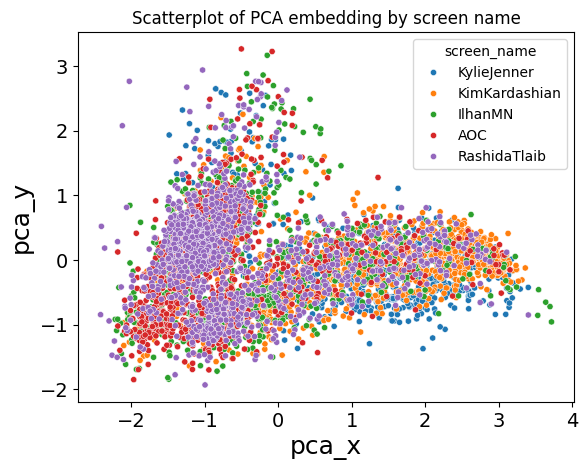

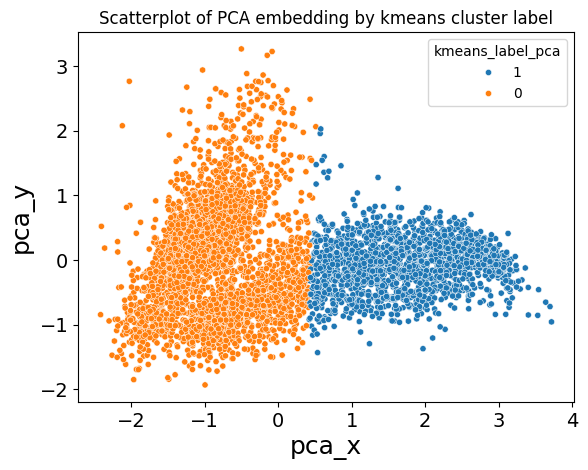

In [ ]:
# prompt: Make two scatter plots of the PCA embedding: one where the hue is the screen name of the user, and the other where the hue is the k-means cluster label. Be sure to include a legend and a title for each plot.

import matplotlib.pyplot as plt
s = 20  #marker size
sns.scatterplot(x='pca_x', y='pca_y', hue='screen_name', s=s, legend='brief', data=df)
plt.title('Scatterplot of PCA embedding by screen name')
plt.show()

sns.scatterplot(x='pca_x', y='pca_y', hue='kmeans_label_pca', s=s, legend='brief', data=df)
plt.title('Scatterplot of PCA embedding by kmeans cluster label')
plt.show()


#### 6. (5 points) Wordcloud and Screen Name Histogram

Plot the word cloud and screen name histogram in each cluster using the `subplot` function (a `for` loop might be useful here).  Don't forget to remove stopwords.

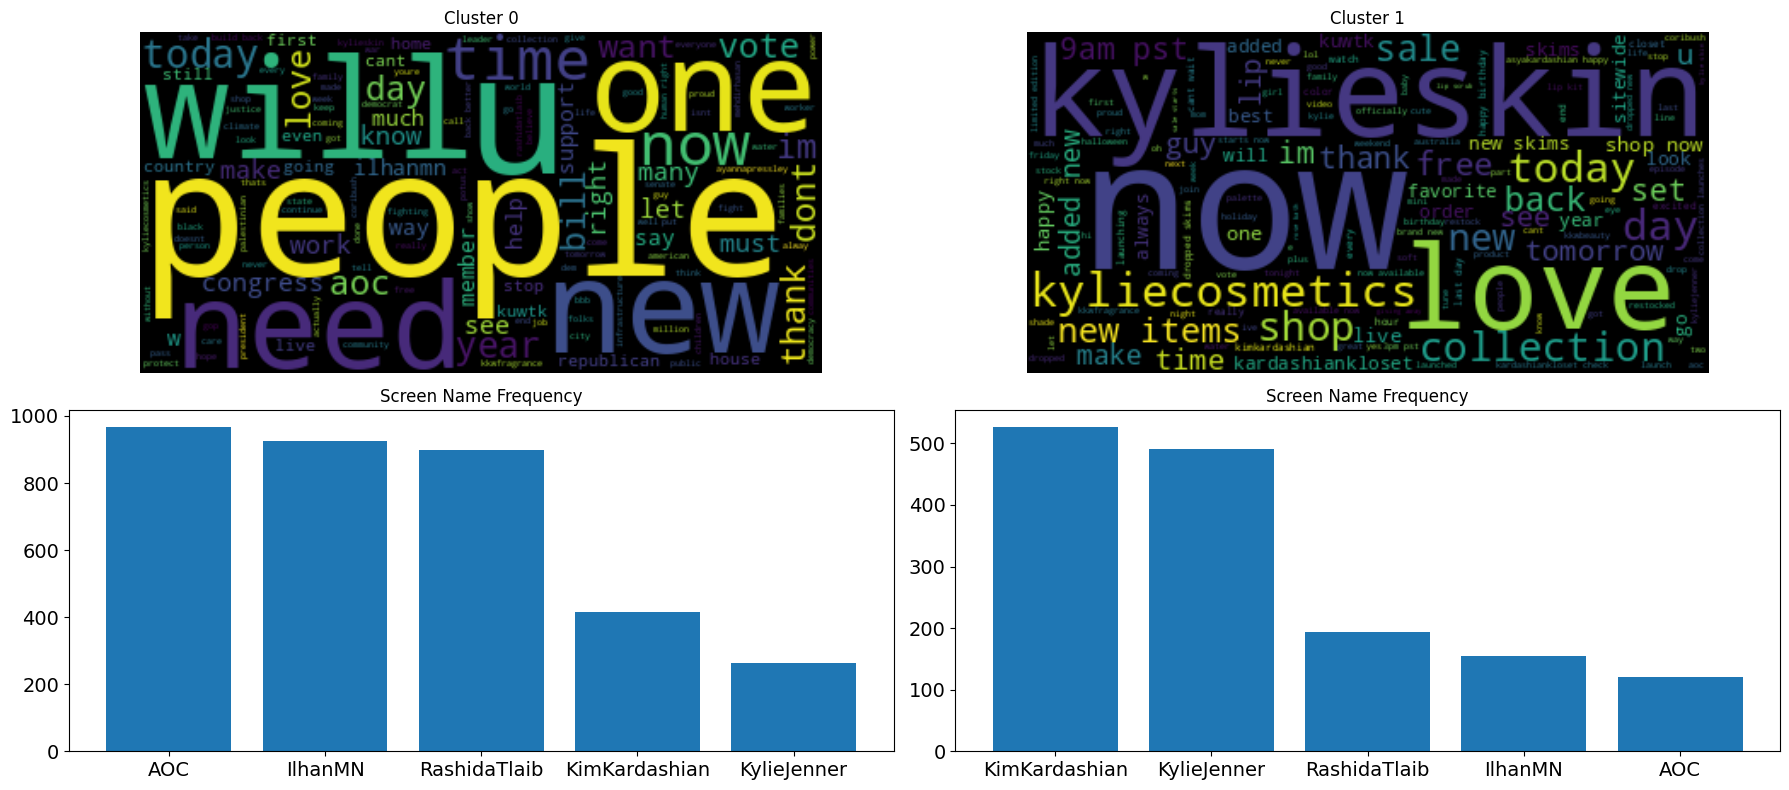

In [ ]:
# prompt: Plot the word cloud and screen name histogram in each cluster using the subplot function (a for loop might be useful here).
df['text_clean'] = df['text'].apply(ta.clean_tweet)  #clean the tweets
df = df[df['text_clean'].str.len() >0]  #remove cleaned tweets of lenght 0

import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

fig, axes = plt.subplots(nrows=2, ncols=n_clusters, figsize=(18, 8))
for i in range(n_clusters):
    cluster_tweets = df[df['kmeans_label_pca'] == str(i)]
    text = " ".join(cluster_tweets['text_clean'].values)
    wordcloud = WordCloud(stopwords=stopwords).generate(text)

    axes[0, i].imshow(wordcloud, interpolation="bilinear")
    axes[0, i].axis("off")
    axes[0, i].set_title(f"Cluster {i}")

    screen_names = cluster_tweets['screen_name'].value_counts()
    axes[1, i].bar(screen_names.index, screen_names.values)
    axes[1, i].set_title(f"Screen Name Frequency")

plt.tight_layout()
plt.show()


#### 7. (2 points) Cluster Analyis

You might notice that in each cluster certain users have many tweets while others have very few.  Look at the screen name histograms and try to identify two distinct communities of users.  Who are in these communities and what is their unifying theme?  It will be helpful to look up who these users are.

In [ ]:
#AOC, IlhanMN, and RashidaTlaib are all US representatives as seen in cluster 0 which has key words that relate to people and politics
#KimKardashian and KylieJenner are both celebrities as seen in cluster 1 which has key words that relate to their products and cosmetics